In [1]:
from lightgbm import LGBMClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
import optuna
from optuna.trial import Trial
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

from typing import List, Any, Tuple
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Data Loading
X_model = pd.read_csv('../data/X_model.csv')
Y_model = pd.read_csv('../data/Y_model.csv')
scaler = MinMaxScaler(feature_range=(0,1))

In [3]:
# Define preprocessors
print("Defining preprocessors...")
def column(colnames: List[str]):
    def _column(X: pd.DataFrame):
        X = X.fillna(0)
        return [
            [colname, X[colname].values] for colname in colnames
        ]
    return _column

def rangesum(
    name:str, 
    regex: str, 
    prefixes: str, 
    dist: np.ndarray
):
    def _rangesum(X: pd.DataFrame):
        X = X.fillna(0)
        return [
            [
                prefix + name, 
                X.filter(regex=(prefix + regex), axis=1).values.dot(dist)
            ] for prefix in prefixes
        ]
    return _rangesum

def _fillna(X: np.ndarray) -> np.ndarray:
    return np.nan_to_num(X, copy=True, nan=0)

def array_divide(
    numerator: List[Tuple[str, np.ndarray]], 
    denominator: List[Tuple[str, np.ndarray]]
) -> List[Any]:
    assert len(numerator) == len(denominator)
    return [
        [
            "r" + numerator_colname, 
            _fillna(np.divide(numerator_col, denominator_col))
        ] for [numerator_colname, numerator_col], [_, denominator_col] in zip(numerator, denominator)
    ]

def one_hot_encode(column: str) -> pd.DataFrame:
    def _one_hot_encode(X: pd.DataFrame):
        X = X.fillna(0)
        df_dummies = pd.get_dummies(X[column], prefix=column)
        return [
            [colname, df_dummies[colname].values] for colname in df_dummies.columns
        ]
    return _one_hot_encode

Defining preprocessors...


In [4]:
def preprocess(X: pd.DataFrame, processors: List[Any]) -> pd.DataFrame:
    X_new = pd.DataFrame()

    for processor in processors:
        for colname, col in processor if type(processor) == type([]) else processor(X):
            X_new[colname] = col

    X_new = X_new.fillna(0)

#     X_new = pd.DataFrame(scaler.fit_transform(X_new), columns=X_new.columns)

    return X_new

In [5]:
def equal_dist(length: int) -> np.ndarray:
    return np.ones(length)

def linear_dist(length: int) -> np.ndarray:
    return np.arange(start=0, stop=1, step=1/length)

In [6]:
print("Data preprocessing...")
dist_GIT = rangesum(
    'GIT', 
    r"202205[0-9]{2}", 
    "cts", 
    equal_dist(31)
)(X_model)
dist_VAT = rangesum(
    'VAT', 
    r"20220[17](?:[01][0-9]|2[0-5])", 
    "ts", 
    np.concatenate((equal_dist(25), equal_dist(25)))
)(X_model)
entire_days = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 25
entire = rangesum(
    'Entire', 
    r"2022[0-9]{4}", 
    "cts", 
    equal_dist(entire_days)
)(X_model)

Data preprocessing...


In [7]:
age_code = np.array(X_model['age_code'])
gender_code = np.array(X_model['gender'])
region_code = np.array(X_model['region_code'])
cat_Featrues = []
cat_Featrues.append(['gender',age_code])
cat_Featrues.append(['age_code',age_code])
cat_Featrues.append(['region_code',region_code])

In [8]:
X_processed = preprocess(
    X_model, 
    [
        cat_Featrues,
        dist_GIT,
        dist_VAT,
        entire,
        # array_divide(dist_GIT, entire), # rel_GIT
        # array_divide(dist_VAT, entire[1:]), # rel_VAT
    ]
)
X_processed.head(3)

,gender,age_code,region_code,cGIT,tGIT,sGIT,tVAT,sVAT,cEntire,tEntire,sEntire
0,13,13,7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,93.0
1,5,5,1,2.0,0.0,17.0,0.0,185.0,39.0,0.0,790.0
2,6,6,2,6.0,3.0,2253.0,0.0,1712.0,26.0,3.0,5119.0


In [9]:
Total = pd.concat([X_processed,Y_model],axis=1)

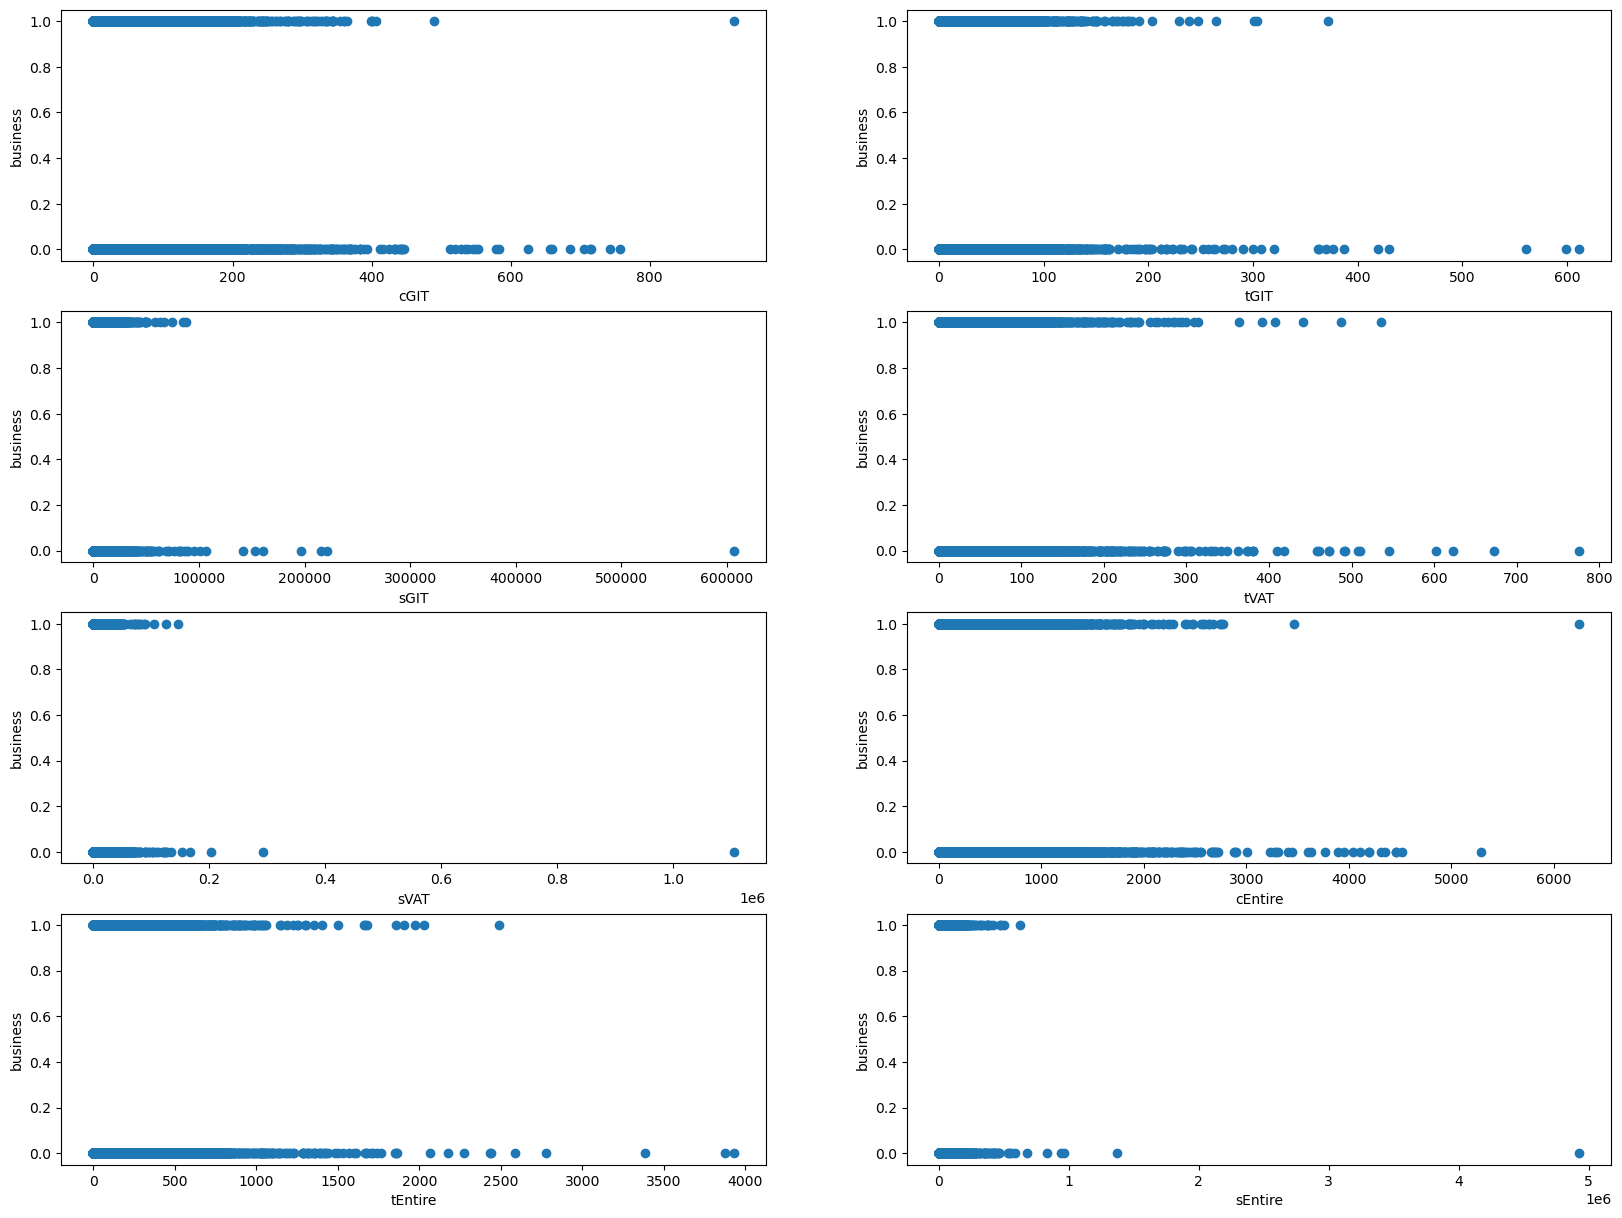

In [10]:
i=1
fig = plt.figure(figsize=(20,15))
for col in ['cGIT', 'tGIT', 'sGIT', 'tVAT', 'sVAT', 'cEntire', 'tEntire','sEntire']:
    x = Total[col]
    y = Total['business']
    plt.subplot(4,2,i)
    i+=1
    plt.scatter(x,y)
    plt.xlabel(col)
    plt.ylabel('business')

In [11]:
a = Total[Total['cGIT']>800].index
b = Total[Total['tGIT']>500].index
c = Total[Total['sGIT']>6000000].index

d = Total[Total['tVAT']>700].index
e = Total[Total['sVAT']>1000000].index

f = Total[Total['cEntire']>5000].index
g = Total[Total['tEntire']>3000].index
h = Total[Total['sEntire']>5000000].index

In [12]:
OL = []
for i in [a,b,c,d,e,f,g,h]:
    for index in i:
        OL.append(index)
OL = list(set(OL))
print(OL)
X_processed.drop(index=OL,inplace=True)
Y_model.drop(index=OL,inplace=True)

[276935, 661865, 15127, 696728, 679738]


In [13]:
#optimize by using optuna
def optimizeLGBM(trial):
    lgbm = LGBMClassifier(
                          task = "train",
                          objective = "binary", #cross-entropy
#                           boosting = "gdbt", #rf
                          n_estimators=trial.suggest_int('n_estimators',100,500),
                          # to deal with overfitting, very important param
                          max_depth = trial.suggest_int('max_depth',10,20),
                          learning_rate = trial.suggest_float('learning_rate',0.02,0.1),
                          num_leaves = trial.suggest_int('num_leaves',500,1000),
                          min_data_in_leaf = trial.suggest_int('min_data_in_leaf',100,1000),
                          metric = "auc",
                          #if max_bin becomes small, the accuracy goes up
                          max_bin = trial.suggest_int('max_bin',255,350),
                          tree_learner = "data",
                          lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
                          lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
                          # to deal with overfitting
                          min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
                          random_state=100,
                          #for bagging imbalanced
                          bagging_fraction = trial.suggest_float('bagging_fraction', 0,1),
                          pos_bagging_fraction = trial.suggest_float('pos_bagging_fraction', 0,1),
                          neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', 0,1),
                          categorical_feature = [0,1,2],
        
#                           is_unbalance = True
                          class_weight={0: 1, 1: 14.291397}
        
#                           boosting = "gdbt", #rf
#                           min_gain_to_split = ,
#                           bagging_fraction = ,
#                           early_stopping_round = ,


    )
    #cross validation K=5
    score = cross_val_score(lgbm, X_processed, Y_model, cv=StratifiedKFold(n_splits=5, shuffle=True),
                            scoring="roc_auc")
    return score.mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)
LGBM_study = optuna.create_study(direction='maximize')
LGBM_study.optimize(optimizeLGBM, show_progress_bar=True, n_trials=10)

# Print the best parameters
print(LGBM_study.best_params)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.0024535071243705965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024535071243705965
[LightGBM] [Warning] min_data_in_leaf is set=644, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=644
[LightGBM] [Warning] lambda_l2 is set=0.03046436032473742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03046436032473742
[LightGBM] [Warning] bagging_fraction is set=0.8035910089215337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8035910089215337
[LightGBM] [Warning] lambda_l1 is set=0.0024535071243705965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024535071243705965
[LightGBM] [Warning] min_data_in_leaf is set=644, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=644
[LightGBM] [Warning] lambda_l2 is set=0.03046436032473742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03046436032473742
[LightGBM] [Warning] bagging_fraction is set=0.80359100

In [14]:
# apply model and fit
optimized_LGBM = LGBMClassifier(task = "predict",
                          objective = "binary", # cross-entropy
#                           boosting = gdbt, #rf
                          n_estimators=LGBM_study.best_params['n_estimators'],
                          # to deal with overfitting, very important param
                          max_depth = LGBM_study.best_params['max_depth'],
                          learning_rate = LGBM_study.best_params['learning_rate'], # if it becomes 0.01(maybe?)the result proba becomes extremely small
                          num_leaves = LGBM_study.best_params['num_leaves'],
                          min_data_in_leaf = LGBM_study.best_params['min_data_in_leaf'],
                          metric = "auc",
                          #if max_bin becomes small, the accuracy goes up
                          max_bin = LGBM_study.best_params['max_bin'],
                          tree_learner = "data",
                          lambda_l1 = LGBM_study.best_params['lambda_l1'],
                          lambda_l2 = LGBM_study.best_params['lambda_l2'],
                          # to deal with overfitting
                          min_child_weight = LGBM_study.best_params['min_child_weight'], #LGBM_study.best_params['min_child_weight']
                          random_state=100,
                          bagging_fraction = LGBM_study.best_params['bagging_fraction'],
                          pos_bagging_fraction = LGBM_study.best_params['pos_bagging_fraction'],
                          neg_bagging_fraction = LGBM_study.best_params['pos_bagging_fraction'],
#                           is_unbalance = True
                          categorical_feature = [0,1,2],
                          class_weight={0: 1, 1: 14.291397}
                               )


[LightGBM] [Warning] lambda_l1 is set=7.146500776882383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.146500776882383
[LightGBM] [Warning] min_data_in_leaf is set=925, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=925
[LightGBM] [Warning] lambda_l2 is set=0.0051273603384750155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0051273603384750155
[LightGBM] [Warning] bagging_fraction is set=0.8528957600978424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8528957600978424
[LightGBM] [Warning] lambda_l1 is set=7.146500776882383, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.146500776882383
[LightGBM] [Warning] min_data_in_leaf is set=925, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=925
[LightGBM] [Warning] lambda_l2 is set=0.0051273603384750155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0051273603384750155
[LightGBM] [Warning] bagging_fraction is set=0.8528957600978424

<BarContainer object of 5 artists>

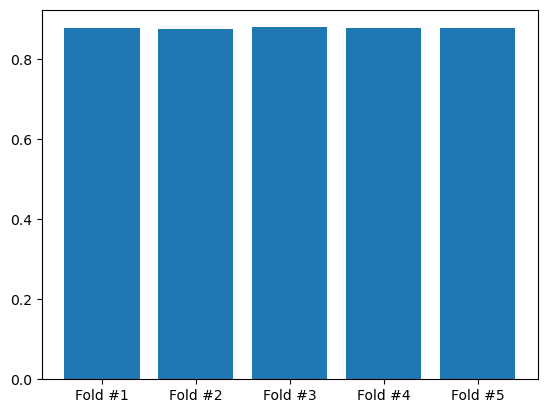

In [15]:
# evaluate
scores = cross_val_score(
    optimized_LGBM, 
    X_processed, 
    Y_model, 
    cv=StratifiedKFold(n_splits=5, shuffle=True
                       ,random_state=100
                      ),
    scoring='roc_auc'
)
print("Average ROC AUC Score", np.mean(scores))
print("Standard Deviation of ROC AUC Score", np.std(scores))
# Plot 5 scores in bar plot
print(scores)
plt.bar(list(map(lambda i: f"Fold #{i}", range(1, 6))), scores)

#0.8753111530570191
#0.8756329404995423
#0.8780611462672319 when iterate 10 times
#0.8786665892827801 when iterate 100 times
#0.8786365497775094 -> trial 7 when iterate 10 times

#0.8778765687408898 ???? why?
#0.8778026069580795 when remove outlier
#0.8783678297299062 when remove outlier + class_weight={0: 1, 1: 14.291397}

In [16]:
print("Data preprocessing...")
X_exam = pd.read_csv('X_exam.csv')
dist_GIT_exam = rangesum(
    'GIT', 
    r"202205[0-9]{2}", 
    "cts", 
    equal_dist(31)
)(X_exam)
dist_VAT_exam = rangesum(
    'VAT', 
    r"20220[17](?:[01][0-9]|2[0-5])", 
    "ts", 
    np.concatenate((equal_dist(25), equal_dist(25)))
)(X_exam)
entire_days = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 25
entire_exam = rangesum(
    'Entire', 
    r"2022[0-9]{4}", 
    "cts", 
    equal_dist(entire_days)
)(X_exam)

Data preprocessing...


FileNotFoundError: [Errno 2] No such file or directory: 'X_exam.csv'

In [ ]:

X_exam_processed = preprocess(
    X_exam, 
    [
        column(['age_code']),
        one_hot_encode('gender'),
        one_hot_encode('region_code'),
        dist_GIT_exam,
        dist_VAT_exam,
        entire_exam
    ]
)

In [ ]:
X_exam_processed.head()

,age_code,gender_1,gender_2,region_code_0,region_code_1,region_code_2,region_code_4,region_code_5,region_code_6,region_code_7,...,region_code_17,region_code_18,cGIT,tGIT,sGIT,tVAT,sVAT,cEntire,tEntire,sEntire
0,0.230769,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.008197,0.0,0.000195,0.004158,0.003473,0.004441,0.000978,0.002425
1,0.692308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.001943,0.000000,0.002560
2,0.230769,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.008197,0.0,0.008194,0.004158,0.020179,0.013322,0.003421,0.009199
3,0.538462,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.002049,0.0,0.000512,0.000000,0.000000,0.003608,0.000000,0.002000
4,0.538462,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.002079,0.003622,0.000278,0.000489,0.000997


In [ ]:
print("Executing...")
Y_exam = np.zeros(X_exam.shape[0])
k = 5
kf = StratifiedKFold(n_splits=k)
for tr_index, val_index in kf.split(X_processed,Y_model):
    X_tr,Y_tr = X_processed.iloc[tr_index],Y_model.iloc[tr_index]
    X_val, Y_val = X_processed.iloc[val_index],Y_model.iloc[val_index]
    
    optimized_LGBM.fit(X_tr,Y_tr,eval_metric='auc',eval_set=[(X_tr,Y_tr),(X_val,Y_val)])
    proba = optimized_LGBM.predict_proba(X_exam_processed)[:,1]
    Y_exam = Y_exam + proba
Y_exam = Y_exam/k
thresholds = np.array([0.5,0.7,0.75,0.8])
# the ratio of high prob with different thresholds
for num in thresholds: 
    filtered = Y_exam[np.where(Y_exam>num)]
    print("the number of probability more than %.2f is %d:" %(num,len(filtered)))
    print("the ratio of probability more than %.2f is : %.4f"%(num, float(len(filtered))/len(Y_exam)))
    print('---------------------------------------------------\n')
# res = pd.DataFrame({'business prob':Y_exam})
# res.to_csv("./part1.csv")
# the number of probability more than 0.50 is 64713:
# the ratio of probability more than 0.50 is : 0.3236
# ---------------------------------------------------

# the number of probability more than 0.70 is 36457:
# the ratio of probability more than 0.70 is : 0.1823
# ---------------------------------------------------

# the number of probability more than 0.75 is 20901:
# the ratio of probability more than 0.75 is : 0.1045
# ---------------------------------------------------

# the number of probability more than 0.80 is 10084:
# the ratio of probability more than 0.80 is : 0.0504
# ---------------------------------------------------

# the number of probability more than 0.50 is 77570:
# the ratio of probability more than 0.50 is : 0.3878
# ---------------------------------------------------

# the number of probability more than 0.70 is 49877:
# the ratio of probability more than 0.70 is : 0.2494
# ---------------------------------------------------

# the number of probability more than 0.75 is 38912:
# the ratio of probability more than 0.75 is : 0.1946
# ---------------------------------------------------

# the number of probability more than 0.80 is 28106:
# the ratio of probability more than 0.80 is : 0.1405
# ---------------------------------------------------

Executing...
[1]	training's auc: 0.868478	valid_1's auc: 0.867066
[2]	training's auc: 0.872429	valid_1's auc: 0.870279
[3]	training's auc: 0.874213	valid_1's auc: 0.871943
[4]	training's auc: 0.874975	valid_1's auc: 0.872607
[5]	training's auc: 0.87555	valid_1's auc: 0.872993
[6]	training's auc: 0.876325	valid_1's auc: 0.873369
[7]	training's auc: 0.876955	valid_1's auc: 0.873786
[8]	training's auc: 0.877613	valid_1's auc: 0.874178
[9]	training's auc: 0.878087	valid_1's auc: 0.874455
[10]	training's auc: 0.878465	valid_1's auc: 0.874651
[11]	training's auc: 0.878731	valid_1's auc: 0.874792
[12]	training's auc: 0.879131	valid_1's auc: 0.874977
[13]	training's auc: 0.879422	valid_1's auc: 0.875074
[14]	training's auc: 0.879836	valid_1's auc: 0.875269
[15]	training's auc: 0.880107	valid_1's auc: 0.875364
[16]	training's auc: 0.880415	valid_1's auc: 0.875513
[17]	training's auc: 0.880711	valid_1's auc: 0.875626
[18]	training's auc: 0.880869	valid_1's auc: 0.875599
[19]	training's auc: 0.88

[44]	training's auc: 0.887656	valid_1's auc: 0.875275
[45]	training's auc: 0.887867	valid_1's auc: 0.875287
[46]	training's auc: 0.888039	valid_1's auc: 0.875309
[47]	training's auc: 0.888177	valid_1's auc: 0.875311
[48]	training's auc: 0.888405	valid_1's auc: 0.875323
[49]	training's auc: 0.888566	valid_1's auc: 0.875355
[50]	training's auc: 0.888754	valid_1's auc: 0.875397
[51]	training's auc: 0.888978	valid_1's auc: 0.875426
[52]	training's auc: 0.88915	valid_1's auc: 0.87544
[53]	training's auc: 0.88938	valid_1's auc: 0.87547
[54]	training's auc: 0.889559	valid_1's auc: 0.875482
[55]	training's auc: 0.889743	valid_1's auc: 0.87549
[56]	training's auc: 0.889907	valid_1's auc: 0.875504
[57]	training's auc: 0.890071	valid_1's auc: 0.875524
[58]	training's auc: 0.890279	valid_1's auc: 0.875563
[59]	training's auc: 0.890428	valid_1's auc: 0.875581
[60]	training's auc: 0.890557	valid_1's auc: 0.875592
[61]	training's auc: 0.890698	valid_1's auc: 0.875592
[62]	training's auc: 0.890841	val

[87]	training's auc: 0.893908	valid_1's auc: 0.877829
[88]	training's auc: 0.893973	valid_1's auc: 0.87784
[89]	training's auc: 0.894083	valid_1's auc: 0.877864
[90]	training's auc: 0.894267	valid_1's auc: 0.877909
[91]	training's auc: 0.894298	valid_1's auc: 0.877918
[92]	training's auc: 0.894409	valid_1's auc: 0.877919
[93]	training's auc: 0.894521	valid_1's auc: 0.87793
[94]	training's auc: 0.894606	valid_1's auc: 0.877964
[95]	training's auc: 0.894752	valid_1's auc: 0.877987
[96]	training's auc: 0.894941	valid_1's auc: 0.878039
[97]	training's auc: 0.895099	valid_1's auc: 0.878045
[98]	training's auc: 0.895201	valid_1's auc: 0.878044
[99]	training's auc: 0.895346	valid_1's auc: 0.878049
[100]	training's auc: 0.89548	valid_1's auc: 0.87805
[LightGBM] [Warning] min_data_in_leaf is set=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] lambda_l1 is set=0.04869700361211202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.048697

[20]	training's auc: 0.881738	valid_1's auc: 0.8787
[21]	training's auc: 0.882028	valid_1's auc: 0.878793
[22]	training's auc: 0.88233	valid_1's auc: 0.878833
[23]	training's auc: 0.882519	valid_1's auc: 0.878884
[24]	training's auc: 0.882756	valid_1's auc: 0.878905
[25]	training's auc: 0.882927	valid_1's auc: 0.878926
[26]	training's auc: 0.883162	valid_1's auc: 0.87895
[27]	training's auc: 0.883347	valid_1's auc: 0.878988
[28]	training's auc: 0.883493	valid_1's auc: 0.878989
[29]	training's auc: 0.883663	valid_1's auc: 0.879006
[30]	training's auc: 0.883889	valid_1's auc: 0.879008
[31]	training's auc: 0.884127	valid_1's auc: 0.879037
[32]	training's auc: 0.884328	valid_1's auc: 0.879065
[33]	training's auc: 0.884549	valid_1's auc: 0.879099
[34]	training's auc: 0.884731	valid_1's auc: 0.879102
[35]	training's auc: 0.884979	valid_1's auc: 0.879108
[36]	training's auc: 0.885166	valid_1's auc: 0.879119
[37]	training's auc: 0.88536	valid_1's auc: 0.879142
[38]	training's auc: 0.885551	val

In [ ]:
## task2
for th in [0.5,0.52,0.53,0.55]:
    profit = 0
    for tr_index, val_index in kf.split(X_processed,Y_model):
        X_tr,Y_tr = X_processed.iloc[tr_index],Y_model.iloc[tr_index]
        X_val, Y_val = X_processed.iloc[val_index],Y_model.iloc[val_index]

        optimized_LGBM.fit(X_tr,Y_tr,eval_metric='auc')
        proba = optimized_LGBM.predict_proba(X_val)[:,1]

        df = pd.DataFrame({'business_prob':proba},index=val_index)
        res = pd.concat([Y_val,df],axis=1)
        filtered = res[res['business_prob']>th]

        profit += filtered['business'].sum()* 500000*0.01 - 400*filtered.shape[0]
    # avg profit
    print("---------------------------------------------------------")
    print("when threshold is %.2f, the avg profit is %.2f" %(th,profit/5))
    print("---------------------------------------------------------")
# when threshold is 0.4, the avg profit is 25932640.00
# when threshold is 0.45, the avg profit is 26372160.00
# when threshold is 0.5, the avg profit is 26628040.00
# when threshold is 0.55, the avg profit is 26650400.00
# when threshold is 0.6, the avg profit is 26306360.00

[LightGBM] [Warning] min_data_in_leaf is set=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] lambda_l1 is set=0.04869700361211202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04869700361211202
[LightGBM] [Warning] bagging_fraction is set=0.24374626955501244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24374626955501244
[LightGBM] [Warning] lambda_l2 is set=8.411720661598768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.411720661598768
[LightGBM] [Warning] min_data_in_leaf is set=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] lambda_l1 is set=0.04869700361211202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04869700361211202
[LightGBM] [Warning] bagging_fraction is set=0.24374626955501244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24374626955501244
[LightGBM] [Warning] lambda_l2 is set=8.411720661598

---------------------------------------------------------
when threshold is 0.53, the avg profit is 26665080.00
---------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] lambda_l1 is set=0.04869700361211202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04869700361211202
[LightGBM] [Warning] bagging_fraction is set=0.24374626955501244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24374626955501244
[LightGBM] [Warning] lambda_l2 is set=8.411720661598768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.411720661598768
[LightGBM] [Warning] min_data_in_leaf is set=172, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=172
[LightGBM] [Warning] lambda_l1 is set=0.04869700361211202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04869700361211202
[LightGBM] [Warning] bagging_fr

In [ ]:

# references
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
# http://devdoc.net/bigdata/LightGBM-doc-2.2.2/Parallel-Learning-Guide.html
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
# https://www.kaggle.com/code/rmiperrier/tps-mar-lgbm-predict-proba-vs-predict/notebook
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://www.kaggle.com/code/kageyama/predict-by-lightgbm
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html